In [343]:
from __future__ import print_function

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable

In [344]:
content_path = "data/itmo.jpg"
style_path = "data/picasso.jpg"
imsize = 400

In [345]:
dtype = torch.FloatTensor
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    image = image.unsqueeze(0)
    return image

In [346]:
unloader = transforms.ToPILImage()


def imshow(tensor):
    image = tensor.clone().cpu()
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    plt.imshow(image)

In [347]:
content = image_loader(content_path).type(dtype)
style = image_loader(style_path).type(dtype)

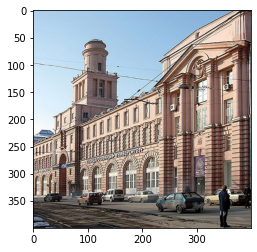

In [348]:
imshow(content.data)

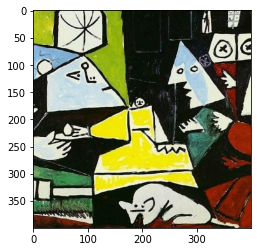

In [349]:
imshow(style.data)

In [350]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.output = None
        self.loss = None
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion.forward(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [351]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        _G = torch.mm(features, features.t())
        return _G.div(a * b * c * d)

In [352]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.output = None
        self.G = None
        self.loss = None
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram.forward(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion.forward(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [353]:
cnn = models.vgg19(pretrained=True).features

In [354]:
content_layers = ['conv_1', 'conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_7']

content_losses = []
style_losses = []

model = nn.Sequential()
gram = GramMatrix()

content_weight = 1
style_weight = 1000


def try_add_layers(name_layer, ind):
    if name_layer in content_layers:
        tg = model.forward(content).clone()
        c_loss = ContentLoss(tg, content_weight)
        model.add_module(f'content_loss_{ind}', c_loss)
        content_losses.append(c_loss)

    if name_layer in style_layers:
        tg_feat = model.forward(style).clone()
        tg_feat_gram = gram.forward(tg_feat)
        st_loss = StyleLoss(tg_feat_gram, style_weight)
        model.add_module(f'style_loss_{ind}', st_loss)
        style_losses.append(st_loss)


i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name_ = f'conv_{i}'
        model.add_module(name_, layer)
        try_add_layers(name_, i)
        continue

    if isinstance(layer, nn.ReLU):
        name_ = f'relu_{i}'
        model.add_module(name_, layer)
        try_add_layers(name_, i)
        i += 1
        continue

    if isinstance(layer, nn.MaxPool2d):
        model.add_module(f'pool_{i}', layer)

In [355]:
input = nn.Parameter((image_loader(content_path).type(dtype)).data)

In [356]:
optimizer = optim.LBFGS([input])

run = [0]
while run[0] <= 500:

    def closure():
        input.data.clamp_(0, 1)

        optimizer.zero_grad()
        model.forward(input)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.backward()
        for cl in content_losses:
            content_score += cl.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f'run {run}')

        return content_score + style_score


    optimizer.step(closure)

input.data.clamp_(0, 1)

run [50]
run [100]
run [150]
run [200]
run [250]
run [300]
run [350]
run [400]
run [450]
run [500]


tensor([[[[5.0278e-01, 3.0608e-01, 3.3041e-01,  ..., 1.0000e+00,
           9.7770e-01, 7.5112e-01],
          [3.4129e-01, 5.8219e-01, 7.0480e-01,  ..., 2.2462e-04,
           1.1433e-01, 1.4129e-01],
          [3.5289e-01, 6.6290e-01, 8.2429e-01,  ..., 1.6740e-01,
           8.4442e-02, 0.0000e+00],
          ...,
          [2.9909e-01, 4.9287e-02, 7.9877e-02,  ..., 2.4933e-01,
           1.4617e-01, 5.7737e-02],
          [7.4777e-03, 0.0000e+00, 1.0524e-02,  ..., 4.7923e-01,
           3.7712e-01, 9.3030e-02],
          [8.6758e-03, 0.0000e+00, 0.0000e+00,  ..., 5.0726e-01,
           5.8085e-01, 5.5057e-01]],

         [[7.4823e-01, 5.0360e-01, 4.6475e-01,  ..., 8.8664e-01,
           9.1601e-01, 8.9854e-01],
          [7.2333e-01, 9.5162e-01, 9.2122e-01,  ..., 6.5235e-02,
           1.1340e-01, 1.4378e-01],
          [7.2062e-01, 9.9879e-01, 9.2875e-01,  ..., 1.1341e-01,
           1.1758e-01, 4.2212e-03],
          ...,
          [7.7088e-02, 4.3062e-02, 4.1643e-02,  ..., 1.5596

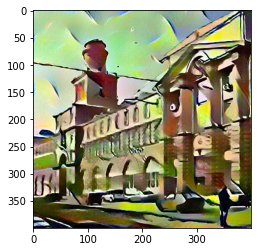

In [357]:
imshow(input.data)